In [ ]:
pip install scikit-learn==0.24.2

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import nltk

import re
import requests
import pandas as pd
import numpy as np
import json
import os
import dotenv
import sys
import lyricsgenius
import base64
from glob import glob
sys.tracebacklimit = 0 # turn off the error tracebacks
import plotly_express as px
#from lib.textparser import TextParser
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from numpy.linalg import norm
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from sklearn.decomposition import PCA
import seaborn as sns

In [3]:
OHCO = ['decade_id', 'song_num', 'stanza_num', 'line_num', 'token_num']

In [4]:
TFIDF = pd.read_csv('data/derived_tables/TFIDF.csv', index_col='decade_id')

In [5]:
DFIDF = pd.read_csv('data/derived_tables/DFIDF.csv', index_col='term_str')

In [334]:
TFIDF_L2 = pd.read_csv('data/derived_tables/TFIDF_L2.csv', index_col='decade_id')

In [335]:
LIB = pd.read_csv('data/core_tables/LIB.csv', index_col='decade_id')

In [436]:
VOCAB = pd.read_csv('data/core_tables/VOCAB.csv', index_col='term_str')#.drop('Unnamed: 0', axis=1)

In [337]:
DOC = TFIDF_L2.reset_index()[['decade_id']]
DOC = DOC.merge(LIB, on='decade_id', how='left')
DOC.set_index(['decade_id'],inplace=True)

# PCA

In [404]:
def get_PCA(X, k, norm_docs = True, center_by_mean = True, center_by_variance = True):
    if norm_docs:
        X = (X.T / np.linalg.norm(X, 2, axis=1)).T
    
    if center_by_mean:
        X = X - X.mean(axis=0)
    
    if center_by_variance:
        X = X / X.std(axis=0)


    pca = PCA(n_components=k)
    pca.fit(X)
    
    loadings = pd.DataFrame(pca.components_.T, index=X.columns)
    loadings.columns = [f'PC{i+1}' for i in range(k)]
    
    dcm = pd.DataFrame(pca.transform(X), index=X.index)
    dcm.columns = [f'PC{i+1}' for i in range(k)]

    top_terms = []
    for i in range(6):
        for j in [0, 1]:
            comp_str = ' '.join(loadings.sort_values(f'PC{i+1}', ascending=bool(j)).head(10).index.to_list())
            top_terms.append((f"PC{i+1}", j, comp_str))
    COMPS = pd.DataFrame(top_terms).set_index([0,1]).unstack()
    COMPS.index.name = 'comp_id'
    COMPS.columns = COMPS.columns.droplevel(0) 
    COMPS = COMPS.rename(columns={0:'pos', 1:'neg'})

    

    COMPS['EVR'] = pca.explained_variance_ratio_
    COMPS['CEVR'] = np.cumsum(pca.explained_variance_ratio_)

    return loadings, dcm, COMPS

LOADINGS, DCM, COMPINF = get_PCA(X=TFIDF_L2, k=6, norm_docs=True, center_by_mean=False, center_by_variance=False)

DCM= DCM.join(LIB)


In [405]:
COMPINF

1,pos,neg,EVR,CEVR
comp_id,,,,
PC1,eheu para que nanananana ahah dey nother y whi...,dit earn jammin chh chhchh scrub deeya di bamb...,2.175788e-01,0.217579
PC2,da built dum eeeoh jam poison che mtv jammin d...,dun earn tonights dit nyu boobooooh uhoh yeeho...,2.075121e-01,0.425091
PC3,jammin chh chhchh eheu doodoo deeya di bambala...,da built dum eeeoh nana dun che poison tonight...,1.997577e-01,0.624849
PC4,que nanananana whip dey y dit te earn el wan,eheu nother drifting kicks para aah reminding ...,1.941245e-01,0.818973
PC5,earn dit eheu scrub li hallelujah ditdit para ...,jammin tonights boobooooh chh chhchh uhoh yeeh...,1.810269e-01,1.000000
PC6,summat tan da chh chhchh dit californication j...,tamed tape pads jam di dey nana doodoo thunder...,2.814603e-32,1.000000


In [406]:
DCM

,PC1,PC2,PC3,PC4,PC5,PC6,Decade,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,source_file_path,song_regex,document_length
decade_id,,,,,,,,,,,,,,,,,,,
0,0.053320,-0.610888,-0.359827,-0.109112,-0.513147,-1.737203e-14,2000s,0.593643,0.760881,-5.696056,0.067888,0.098199,0.037857,0.182493,0.537506,124.994357,data/decades/2000s.txt,\[Trackname:\s[^\]]+\]\s\[Artist:\s[^\]]+\],216931
1,0.465543,-0.068188,0.338231,-0.606870,0.296958,2.740355e-15,2010s,0.634008,0.673200,-6.217608,0.064475,0.166805,0.022972,0.177836,0.461077,118.889683,data/decades/2010s.txt,\[Trackname:\s[^\]]+\]\s\[Artist:\s[^\]]+\],195291
2,0.571554,0.125491,0.061079,0.679116,0.026109,2.227450e-14,2020s,0.675517,0.619595,-6.329922,0.079997,0.284910,0.009680,0.183418,0.542036,122.167810,data/decades/2020s.txt,\[Trackname:\s[^\]]+\]\s\[Artist:\s[^\]]+\],212348
3,-0.460046,0.227487,0.614017,0.041414,-0.393928,-3.075304e-15,70s,0.571966,0.611978,-10.020067,0.053069,0.310864,0.032363,0.171034,0.632270,122.576472,data/decades/70s.txt,\[Trackname:\s[^\]]+\]\s\[Artist:\s[^\]]+\],127933
4,-0.113427,0.658761,-0.566349,-0.205959,-0.012720,1.448374e-15,80s,0.618161,0.681151,-9.199699,0.048652,0.177320,0.023871,0.155342,0.664387,119.188785,data/decades/80s.txt,\[Trackname:\s[^\]]+\]\s\[Artist:\s[^\]]+\],151152
5,-0.516944,-0.332663,-0.087151,0.201411,0.596729,-6.084617e-15,90s,0.572694,0.718213,-7.624593,0.048655,0.110941,0.060286,0.175645,0.585344,115.385731,data/decades/90s.txt,\[Trackname:\s[^\]]+\]\s\[Artist:\s[^\]]+\],174393


### Top 5 Loadings for 1st Component

In [407]:
COMPINF.loc['PC1']['pos'].split()[:5]

['eheu', 'para', 'que', 'nanananana', 'ahah']

In [380]:
LOADINGS['PC1'].sort_values(ascending=False).to_frame().head(5)

,PC1
eheu,0.196009
para,0.145991
que,0.142702
nanananana,0.136829
ahah,0.121338


### Bottom 5 Loadings for 2nd Component

In [395]:
COMPINF.loc['PC2']['neg'].split()[:5]

['dun', 'earn', 'tonights', 'dit', 'nyu']

In [209]:
LOADINGS['PC2'].sort_values(ascending=True).to_frame().head(5)

,PC2
dun,-0.209572
earn,-0.173628
tonights,-0.169237
dit,-0.168794
nyu,-0.166583


## PCA Visualization 1

In [414]:
fig = px.scatter(DCM, "PC1", "PC2", color='loudness', hover_name='Decade', marginal_x='box', symbol=None, size=None, height=800)

for i, row in DCM.iterrows():
    fig.add_annotation(x=row['PC1'], y=row['PC2'], text=row['Decade'], showarrow=True)

fig.show()

In [397]:
px.scatter(LOADINGS.join(VOCAB).reset_index().rename({'index':'term_str'}, axis=1), "PC1", "PC2", 
    text='term_str', hover_name='term_str',
    size='dfidf', marginal_x='box', height=800)

## PCA Visualization 2

In [412]:
fig = px.scatter(DCM, "PC2", "PC3", color='acousticness', hover_name='Decade', hover_data=['Decade'], marginal_x='box', symbol=None, size=None, height=800)

for i, row in DCM.iterrows():
    fig.add_annotation(x=row['PC2'], y=row['PC3'], text=row['Decade'], showarrow=True)

fig.show()

In [399]:
px.scatter(LOADINGS.join(VOCAB).reset_index().rename({'index':'term_str'}, axis=1), "PC2", "PC3", 
    text='term_str', hover_name='term_str',
    size='dfidf', marginal_x='box', height=800)

# LDA

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly_express as px

In [437]:
DTM = pd.read_csv('data/derived_tables/DTM.csv', index_col='decade_id')
DTM

,1,10k,1k,1s,2,220kid,22nd,2g,2k,3,...,zone,zu,zum,zumban,zón,è,él,еlla,еsta,еyes
decade_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
2,1,2,0,0,1,1,1,0,3,0,...,1,0,0,2,1,0,3,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,1,2,0,0,12,0,0,0,0
5,0,0,0,0,1,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0


In [20]:
DOCS = pd.read_csv('data/derived_tables/DOC.csv', index_col='decade_id')
DOCS

,song_num,doc_str,n_tokens
decade_id,,,
0,0,heres the thing we started out friends it was ...,279
0,1,sweet disposition never too soon oh reckless a...,231
0,2,walking on a dream how can i explain talking t...,252
0,3,five four three two one ah you were a child cr...,220
0,4,if i told you things i did before told you how...,307
...,...,...,...
5,103,oohohohoh come on oh yeah well i tried to tell...,517
5,104,you and me we come from different worlds you l...,299
5,105,lifes like a road that you travel on when ther...,390


In [326]:
ngram_range = (1, 2)
n_terms = 4000
n_topics = 20
max_iter = 20
n_top_terms = 8

In [327]:

count_engine = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names()

In [328]:
lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

In [329]:
TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]

## THETA

In [330]:

lda_model = lda_engine.fit_transform(count_model)
THETA = pd.DataFrame(lda_model, index=DOCS.index)
THETA.columns.name = 'topic_id'
THETA.columns = TNAMES
THETA.sample(10).T

decade_id,2,3,0,1,0,4,5,3,0,0
T00,0.000211,0.000362,0.000352,0.000417,0.000333,0.991204,0.000272,0.000226,0.000307,0.000294
T01,0.000211,0.000362,0.000352,0.000417,0.000333,0.000463,0.000272,0.000226,0.000307,0.000294
T02,0.000211,0.000362,0.000352,0.000417,0.079241,0.000463,0.000272,0.000226,0.823119,0.000294
T03,0.000211,0.000362,0.000352,0.000417,0.000333,0.000463,0.000272,0.000226,0.171359,0.000294
T04,0.000211,0.093003,0.000352,0.000417,0.739081,0.000463,0.000272,0.857697,0.000307,0.000294
T05,0.000211,0.000362,0.000352,0.000417,0.000333,0.000463,0.000272,0.000226,0.000307,0.000294
T06,0.000211,0.000362,0.000352,0.000417,0.000333,0.000463,0.000272,0.000226,0.000307,0.000294
T07,0.000211,0.000362,0.000352,0.000417,0.000333,0.000463,0.000272,0.000226,0.000307,0.000294
T08,0.000211,0.000362,0.000352,0.000417,0.026784,0.000463,0.000272,0.000226,0.000307,0.000294
T09,0.000211,0.000362,0.000352,0.000417,0.000333,0.000463,0.000272,0.000226,0.000307,0.000294


## PHI

In [331]:

PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
PHI.index.name = 'topic_id'
PHI.columns.name = 'term_str'
PHI.T.sample(10).style

topic_id,T00,T01,T02,T03,T04,T05,T06,T07,T08,T09,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19
term_str,,,,,,,,,,,,,,,,,,,,
comin home,0.050000,0.050000,4.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,4.050000,0.050000,0.050000,1.050000,0.050000,0.050000,0.050000
pop,0.050000,0.050000,0.050000,0.050000,12.707573,0.050000,2.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,1.392427
did,1.050337,7.907559,6.750841,2.612522,12.478883,0.050000,9.902595,1.140255,28.526326,24.827345,52.554766,0.050000,0.052195,16.217885,6.730912,3.694196,2.146246,0.050000,1.171154,11.085984
yeah life,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,1.050000,0.050000,0.050000,0.050000,0.050000,11.050000,0.050000,0.050000,2.050000,0.050000,0.050000
said goodbye,0.050000,0.050000,0.050000,0.050000,0.050000,1.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,13.024781,0.050000,1.075219,0.050000,0.050000,0.050000
warm bright,0.050000,13.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
like child,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,1.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,4.935388,1.164612,0.050000,0.050000,1.050000
whips chains,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,10.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
déjà vu,9.763401,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,4.336599


In [332]:
TOPICS = PHI.stack().groupby('topic_id')\
    .apply(lambda x: ' '.join(x.sort_values(ascending=False).head(n_top_terms).reset_index().term_str))\
    .to_frame('top_terms')

TOPICS.head()

,top_terms
topic_id,
T00,waiting ive uh oh chh chhchh chh chhchh sound
T01,come im youre dance oh lady wanna know
T02,got away tell want dont yeah mmm oh
T03,im yeah day like just make pump miss
T04,yeah yeah yeah just na dont im love na na


In [333]:
TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()
TOPICS.sort_values('doc_weight_sum', ascending=False).head()

,top_terms,doc_weight_sum,term_freq
topic_id,,,
T04,yeah yeah yeah just na dont im love na na,73.834718,0.117726
T19,love know im dont oh ill like got,68.571992,0.094179
T15,hey oh hey hey im dont oh oh baby yeah,52.591892,0.075517
T13,way got just dont youre want light hold,50.956173,0.063163
T09,im dont yeah got ill feel oh just,40.697028,0.056307


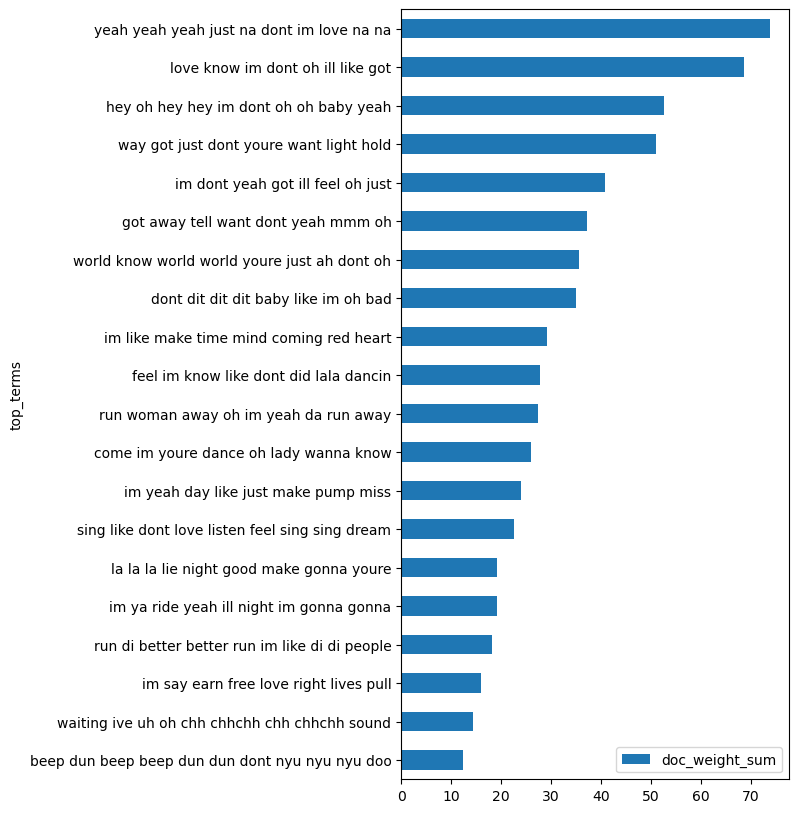

In [300]:
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='top_terms', figsize=(5, n_topics/2));

## LDA + PCA Visualization

In [400]:
LOADINGS_T, DCM_T, COMPINF_T = get_PCA(X=PHI, k=6, norm_docs=True, center_by_mean=False, center_by_variance=False)

In [401]:
DCM_T.join(TOPICS)

,PC1,PC2,PC3,PC4,PC5,PC6,top_terms,doc_weight_sum,term_freq
topic_id,,,,,,,,,
T00,0.090249,0.046316,-0.319846,0.313266,-0.312234,0.188586,waiting ive uh oh chh chhchh chh chhchh sound,14.469237,0.021865
T01,-0.108642,-0.098393,-0.194320,-0.013022,-0.088928,0.121717,come im youre dance oh lady wanna know,25.887939,0.047644
T02,-0.130475,0.112069,-0.042427,0.063017,-0.021222,-0.276618,got away tell want dont yeah mmm oh,37.265235,0.058547
T03,-0.108870,-0.261195,0.147612,-0.220349,-0.103867,-0.288054,im yeah day like just make pump miss,24.065631,0.040736
T04,-0.221781,-0.113662,-0.001456,-0.110575,-0.115006,-0.231637,yeah yeah yeah just na dont im love na na,73.834718,0.117726
T05,0.083017,-0.153546,0.203085,-0.332536,-0.205185,0.598206,im say earn free love right lives pull,16.059108,0.027092
T06,-0.178191,0.248104,0.066414,0.077787,0.079212,0.041224,dont dit dit dit baby like im oh bad,35.021775,0.054339
T07,-0.098397,0.215852,-0.047936,0.077276,0.385408,0.100228,sing like dont love listen feel sing sing dream,22.673769,0.027992
T08,0.260311,-0.364692,0.384848,0.473501,0.234109,0.106293,run di better better run im like di di people,18.161272,0.030428


In [420]:
fig = px.scatter(DCM_T.join(TOPICS), "PC1", "PC2", color='doc_weight_sum', hover_name='top_terms', hover_data=['doc_weight_sum'], marginal_x='box', symbol=None, size='doc_weight_sum', height=800)

for i, row in DCM_T.join(TOPICS).iterrows():
    fig.add_annotation(x=row['PC1'], y=row['PC2'], text=row['top_terms'], showarrow=True, opacity = .5)

fig.show()

# Sentiment

## Sentiment VOCAB_SENT

In [33]:
SALEX = pd.read_csv('data/other/salex_nrc.csv').set_index('term_str')
SALEX.columns = [col.replace('nrc_','') for col in SALEX.columns]
emo_cols = "anger anticipation disgust fear joy sadness surprise trust sentiment".split()

In [421]:
VOCAB_SENT = pd.concat([VOCAB.reset_index().set_index('term_str'), SALEX], join='inner', axis=1)



,n,n_chars,p,i,max_pos,max_pos_group,stem_porter,stop,dfidf,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,sentiment
term_str,,,,,,,,,,,,,,,,,,,,
abandon,1,7,0.000005,17.660497,NN,NN,abandon,0,2.584963,0,0,0,1,0,1,0,1,0,0,-1
abandoned,1,9,0.000005,17.660497,JJ,JJ,abandon,0,2.584963,1,0,0,1,0,1,0,1,0,0,-1
abortion,1,8,0.000005,17.660497,NN,NN,abort,0,2.584963,0,0,1,1,0,1,0,1,0,0,-1
absence,2,7,0.000010,16.660497,NN,NN,absenc,0,3.169925,0,0,0,1,0,1,0,1,0,0,-1
abuse,1,5,0.000005,17.660497,NN,NN,abus,0,2.584963,1,0,1,1,0,1,0,1,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wreck,5,5,0.000024,15.338569,VB,VB,wreck,0,3.000000,1,0,1,1,0,1,0,1,1,0,-1
yearning,1,8,0.000005,17.660497,NN,NN,yearn,0,2.584963,0,1,0,0,1,1,1,0,0,1,0
yell,1,4,0.000005,17.660497,VBP,VB,yell,0,2.584963,1,0,0,1,0,1,0,0,1,0,-1


## Sentiment BOW_SENT

In [422]:
BOW = pd.read_csv('data/derived_tables/BOW.csv', index_col=['decade_id', 'term_str'])
BOW_SENT = BOW.join(VOCAB_SENT[['max_pos'] + emo_cols], on='term_str', rsuffix='_v').dropna()

In [423]:
BOW_SENT

n     tfidf max_pos  anger  anticipation  disgust  fear  \
decade_id term_str                                                             
0         abandon    1  0.001685      NN    0.0           0.0      0.0   1.0   
          abortion   1  0.001685      NN    0.0           0.0      1.0   1.0   
          aching     1  0.000381      NN    0.0           0.0      0.0   0.0   
          afraid     3  0.000514      JJ    0.0           0.0      0.0   1.0   
          alive      6  0.000000      JJ    0.0           1.0      0.0   0.0   
...                 ..       ...     ...    ...           ...      ...   ...   
5         worried    6  0.002351      JJ    0.0           0.0      0.0   0.0   
          worry      2  0.000000     VBP    0.0           1.0      0.0   1.0   
          worse      2  0.000784     JJR    0.0           0.0      0.0   1.0   
          yell       1  0.001731     VBP    1.0           0.0      0.0   1.0   
          young     12  0.000000      JJ    0.0           1.0      0.0   0.0   

                    joy  sadness  surprise  trust  sentiment  
decade_id term_str                                            
0         abandon   0.0      1.0       0.0    0.0       -1.0  
          abortion  0.0      1.0       0.0    0.0       -1.0  
          aching    0.0      1.0       0.0    0.0       -1.0  
          afraid    0.0      0.0       0.0    0.0       -1.0  
          alive     1.0      0.0       0.0    1.0        1.0  
...                 ...      ...       ...    ...        ...  
5         worried   0.0      1.0       0.0    0.0       -1.0  
          worry     0.0      1.0       0.0    0.0       -1.0  
          worse     0.0      1.0       0.0    0.0       -1.0  
          yell      0.0      0.0       1.0    0.0       -1.0  
          young     1.0      0.0       1.0    0.0        1.0  

[2228 rows x 12 columns]

## Sentiment DOC_SENT

In [428]:
EMO_DECADES = BOW_SENT.groupby(['decade_id'])[emo_cols].mean()
EMO_DECADES.index = LIB.Decade
EMO_DECADES = EMO_DECADES.reindex(['70s', '80s', '90s', '2000s', '2010s', '2020s'])
DOC_SENT = EMO_DECADES
EMO_DECADES


,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,sentiment
Decade,,,,,,,,,
70s,0.271028,0.267913,0.199377,0.320872,0.336449,0.323988,0.183801,0.327103,-0.084112
80s,0.304843,0.296296,0.205128,0.367521,0.364672,0.313390,0.173789,0.344729,-0.054131
90s,0.282609,0.275362,0.224638,0.347826,0.309179,0.318841,0.181159,0.292271,-0.130435
2000s,0.287105,0.301703,0.194647,0.362530,0.340633,0.326034,0.177616,0.355231,-0.082725
2010s,0.278997,0.288401,0.172414,0.341693,0.319749,0.313480,0.166144,0.319749,-0.119122
2020s,0.291262,0.286408,0.203883,0.293689,0.337379,0.293689,0.167476,0.315534,-0.094660


In [425]:
def plot_sentiments(df, emo='sentiment'):
    FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
    df[emo].plot(**FIG)

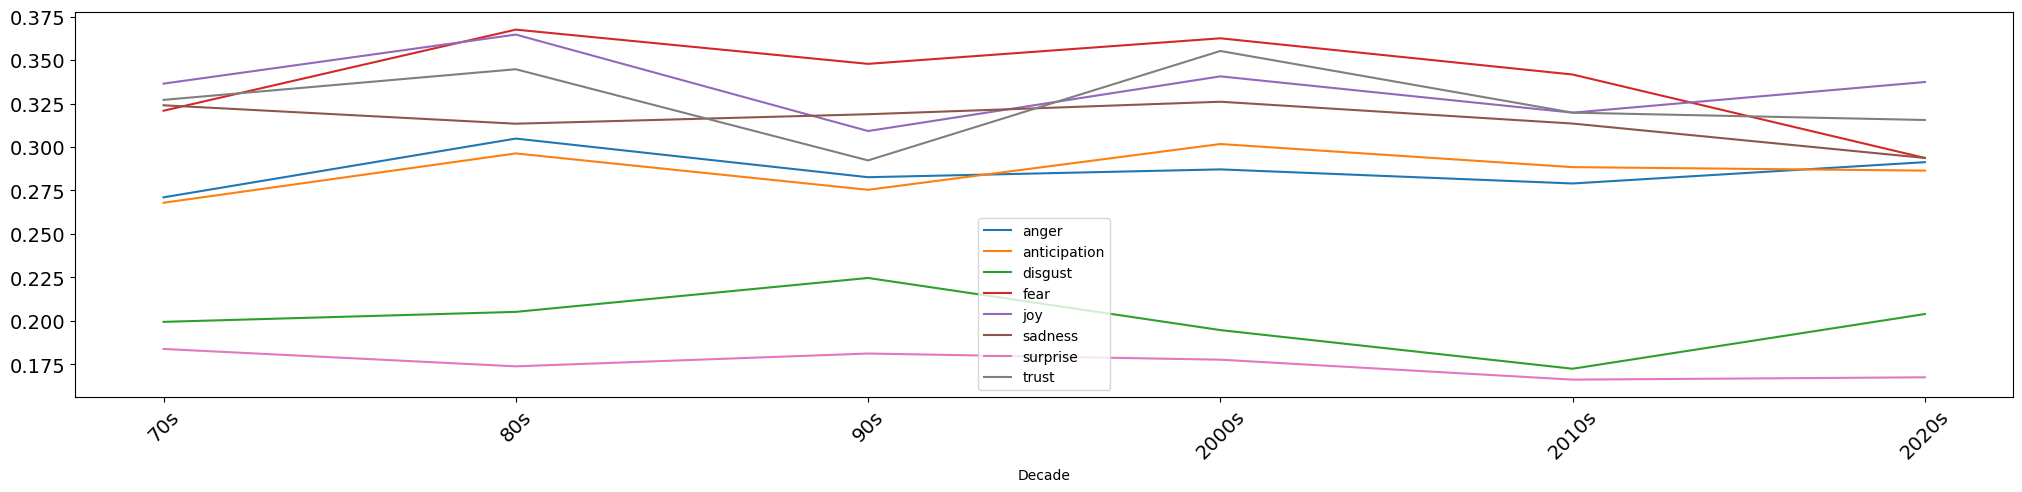

In [426]:
plot_sentiments(EMO_DECADES, "anger anticipation disgust fear joy sadness surprise trust".split())

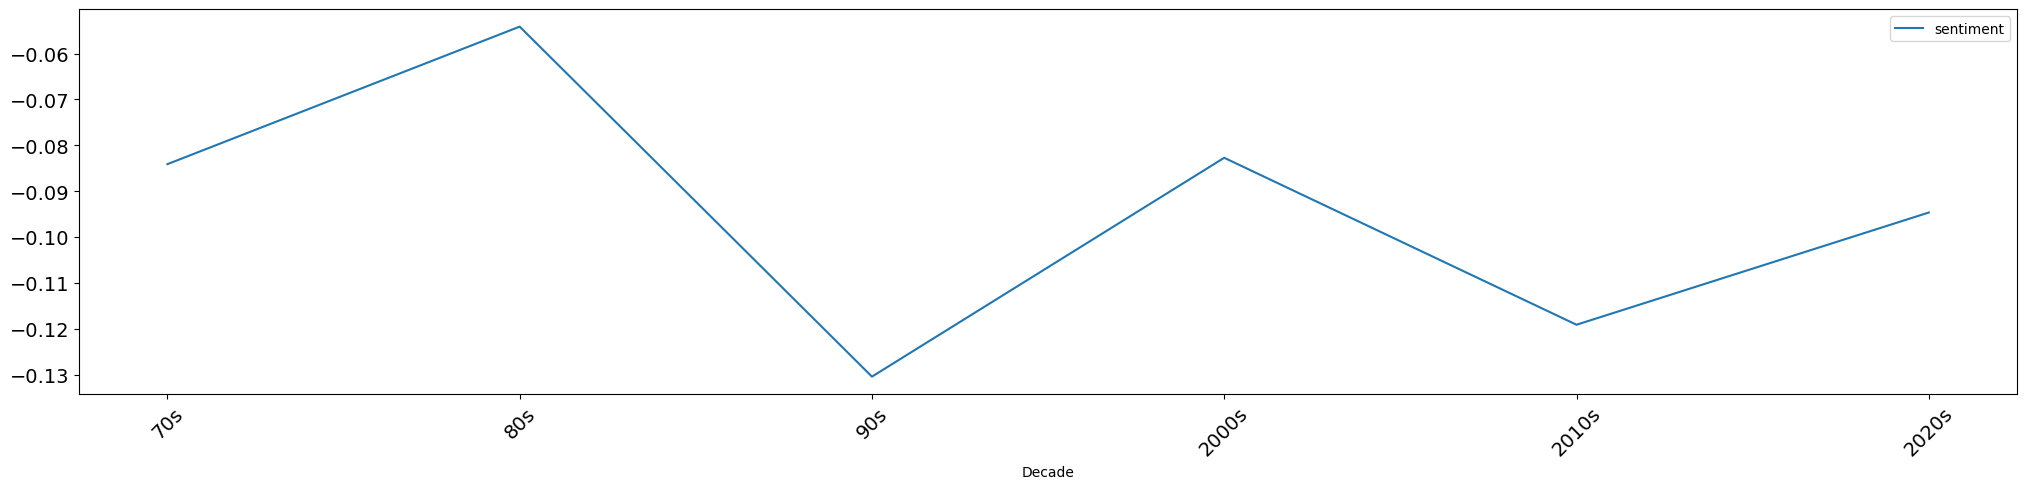

In [427]:
plot_sentiments(EMO_DECADES)

# Word Embeddings

In [ ]:
pip install scikit-learn==0.24.0

In [42]:
from gensim.models import word2vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE as tsne
import plotly_express as px

In [43]:
import gensim
gensim.__version__

'4.3.0'

In [44]:
bags = dict(
    SENTS = OHCO[:4],
    STANZAS = OHCO[:3],
    SONGS = OHCO[:2],
    DECADES = OHCO[:1]
)

BAG = bags['DECADES']

In [45]:
CORPUS = pd.read_csv('data/core_tables/CORPUS.csv', index_col=OHCO)
CORPUS

pos_tuple  pos  \
decade_id song_num stanza_num line_num token_num                            
0         0        0          0        0           ("Here's", 'NNP')  NNP   
                                       1               ('the', 'DT')   DT   
                                       2            ('thing,', 'NN')   NN   
                                       3               ('we', 'PRP')  PRP   
                                       4          ('started', 'VBD')  VBD   
...                                                              ...  ...   
5         107      9          2        1            ("y'all", 'PRP')  PRP   
                                       2             ('deep', 'VBP')  VBP   
                              3        0             ("Y'all", 'DT')   DT   
                                       1              ('are', 'VBP')  VBP   
                                       2            ('crazy,', 'JJ')   JJ   

                                                 token_str term_str pos_group  
decade_id song_num stanza_num line_num token_num                               
0         0        0          0        0            Here's    heres        NN  
                                       1               the      the        DT  
                                       2            thing,    thing        NN  
                                       3                we       we        PR  
                                       4           started  started        VB  
...                                                    ...      ...       ...  
5         107      9          2        1             y'all     yall        PR  
                                       2              deep     deep        VB  
                              3        0             Y'all     yall        DT  
                                       1               are      are        VB  
                                       2            crazy,    crazy        JJ  

[207176 rows x 5 columns]

In [46]:
docs = CORPUS[~CORPUS.pos.str.match('NNPS?')].dropna(subset=['term_str'])\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
docs = [doc for doc in docs if len(doc) > 1] # Lose single word docs

In [47]:
pd.DataFrame(docs)

,0,1,2,3,4,5,6,7,8,9,...,38751,38752,38753,38754,38755,38756,38757,38758,38759,38760
0,the,thing,we,started,out,friends,it,was,cool,but,...,home,with,the,one,in,the,bed,til,dawn,with
1,shirt,now,red,my,bloody,nose,youre,on,your,tippy,...,None,None,None,None,None,None,None,None,None,None
2,and,teasin,sittin,on,him,all,of,my,diamonds,are,...,None,None,None,None,None,None,None,None,None,None
3,blue,jean,baby,lady,seamstress,for,the,band,prettyeyed,pirate,...,None,None,None,None,None,None,None,None,None,None
4,turn,around,every,now,and,then,i,get,a,little,...,None,None,None,None,None,None,None,None,None,None
5,oh,a,scrub,is,a,guy,that,thinks,hes,fly,...,None,None,None,None,None,None,None,None,None,None


In [48]:
w2v_params = dict(
    window = 5,
    vector_size = 246,
    min_count = 20, # THIS LIMITS OUR VOCAB
    workers = 4
)

In [49]:
w2v_model = word2vec.Word2Vec(docs, **w2v_params)

w2v_model.wv.vectors

array([[-0.0455825 , -0.01146243,  0.04625314, ...,  0.09293769,
         0.40599614,  0.1028338 ],
       [ 0.0051288 , -0.11076251,  0.08715875, ...,  0.07768719,
         0.40938693,  0.08848752],
       [ 0.04298154, -0.25185844, -0.05394915, ...,  0.17910035,
         0.22294153,  0.08620101],
       ...,
       [-0.00096087, -0.05845866, -0.0355326 , ..., -0.01308305,
         0.08204432,  0.02103147],
       [-0.00383528, -0.03777458, -0.01193432, ...,  0.0029331 ,
         0.04887708,  0.00740014],
       [ 0.00429545, -0.03834146, -0.01154004, ...,  0.00051022,
         0.06060081,  0.01036917]], dtype=float32)

In [51]:
VOCAB.index = VOCAB.index.astype('str')

In [432]:
def get_vector(row):
    w = row.name
    try:
        vec = w2v_model.wv[w]
    except KeyError as e:
        vec = None
    return vec
WV = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)
VOCAB_W2V = WV

WV

,0,1,2,3,4,5,6,7,8,9,...,236,237,238,239,240,241,242,243,244,245
term_str,,,,,,,,,,,,,,,,,,,,,
a,-0.000697,-0.147161,0.001073,-0.063214,-0.087332,-0.078605,-0.318565,0.176623,-0.162906,-0.091995,...,-0.271357,0.064790,0.115795,0.096995,-0.212346,-0.128673,0.229913,0.022354,0.134102,0.033161
aah,0.042826,-0.188834,0.062527,-0.041070,0.028062,-0.139286,-0.173663,0.028933,-0.047124,-0.185740,...,-0.227731,0.073975,0.083972,0.066990,-0.220039,-0.113884,0.163727,-0.052143,0.137909,0.050333
about,-0.012490,-0.072959,-0.055094,-0.010158,-0.027660,-0.097873,-0.246337,0.076196,-0.066850,-0.131029,...,-0.191778,0.022570,0.167393,0.036212,-0.203870,-0.104577,0.122989,0.002017,0.185268,0.066892
above,0.007541,-0.068235,-0.022983,-0.003271,-0.002605,-0.059942,-0.127548,0.057131,-0.051147,-0.088242,...,-0.126076,0.024104,0.095599,0.027659,-0.124740,-0.057432,0.079269,0.004155,0.106825,0.021701
across,-0.001012,-0.042744,-0.022339,0.001266,0.002300,-0.043447,-0.077863,0.044152,-0.043426,-0.060546,...,-0.088894,0.024965,0.054763,0.016624,-0.083994,-0.044192,0.045679,0.000461,0.061345,0.017974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
your,0.000991,-0.141918,0.040480,-0.048959,-0.063564,-0.163298,-0.385654,-0.025229,0.008331,-0.205723,...,-0.107679,-0.004729,0.181916,-0.008537,-0.168501,0.012658,0.193756,0.092923,0.303993,0.016068
youre,-0.008073,-0.132966,0.006580,-0.036383,-0.063962,-0.188854,-0.296717,0.054342,-0.031046,-0.243642,...,-0.255313,0.047126,0.167139,0.002357,-0.205377,-0.085942,0.132311,0.052297,0.260036,0.046706
yours,0.005136,-0.046219,-0.023736,-0.001191,-0.002733,-0.046451,-0.092428,0.040727,-0.038403,-0.067896,...,-0.104471,0.020650,0.071013,0.022535,-0.091550,-0.056452,0.058797,-0.003921,0.071474,0.013733


## tSNE Plot

In [53]:
tsne_engine = tsne(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=42)
tsne_model = tsne_engine.fit_transform(WV.to_numpy())

In [54]:
TSNE = pd.DataFrame(tsne_model, columns=['x','y'], index=WV.index)
TSNE

,x,y
term_str,,
a,36.352039,-15.384941
aah,27.375029,-9.828051
about,35.977631,-4.845955
above,-1.843330,2.771068
across,-31.760298,4.858816
...,...,...
your,40.176212,4.715441
youre,40.615421,0.054191
yours,-19.442827,3.326664


In [55]:
X = TSNE.join(VOCAB, how='left')
px.scatter(X.reset_index(), 'x', 'y', 
           text='term_str', 
           color='max_pos_group', 
           hover_name='term_str',          
           size='dfidf',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

# RIFFS

## RIFF 1

### LDA + PCA Visualization combined with LIB table to see decade with highest weight

In [56]:
grouped_sum_theta = THETA.groupby('decade_id').sum().T

max_decades_weights = grouped_sum_theta.idxmax(axis=1)

THETA_with_decades = pd.DataFrame({'Term': grouped_sum_theta.index, 'Decade_with_highest_weight': max_decades_weights})

decade_mapping = LIB['Decade'].to_dict()

DCM_with_TOPICS_THETA = DCM_T.join(TOPICS).join(THETA_with_decades)

DCM_with_TOPICS_THETA['Decade_with_highest_weight'] = DCM_with_TOPICS_THETA['Decade_with_highest_weight'].map(decade_mapping)

DCM_with_TOPICS_THETA

px.scatter(DCM_with_TOPICS_THETA, "PC1", "PC2", color='Decade_with_highest_weight', hover_name='doc_weight_sum', \
           hover_data=['doc_weight_sum'], marginal_x='box', symbol=None, size='doc_weight_sum', height=800)

## RIFF 2

### Hierarchical Clustering

In [57]:
from numpy.linalg import norm
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch

In [58]:
L0 = TFIDF.astype('bool').astype('int') # Binary (Pseudo L)
L1 = TFIDF.apply(lambda x: x / x.sum(), 1) # Probabilistic
L2 = TFIDF.apply(lambda x: x / norm(x), 1) # Pythagorean, AKA Euclidean

PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([LIB.index.tolist(), LIB.index.tolist()])).reset_index()

# Keep only unique pairs of different books
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])

# Name index cols
PAIRS.index.names = ['doc_a', 'doc_b']

In [59]:
PAIRS['cityblock'] = pdist(TFIDF, 'cityblock')
PAIRS['euclidean'] = pdist(TFIDF, 'euclidean')
PAIRS['cosine'] = pdist(TFIDF, 'cosine')
PAIRS['jaccard'] = pdist(L0, 'jaccard')
PAIRS['dice'] = pdist(L0, 'dice')
PAIRS['js'] = pdist(L1, 'jensenshannon')  

In [60]:
def hierarchical_cluster(sims, linkage_method='complete', color_thresh=.3, figsize=(10, 10)):

    tree = sch.linkage(sims, method=linkage_method)
    labels = LIB.Decade.values
    
    plt.figure()
    fig, axes = plt.subplots(figsize=(figsize))
    
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    
    plt.tick_params(axis='both', which='major', labelsize=14)

In [61]:
PAIRS.euclidean

doc_a  doc_b
0      1        0.275816
       2        0.298262
       3        0.404064
       4        0.320329
       5        0.333441
1      2        0.283825
       3        0.394451
       4        0.308637
       5        0.337635
2      3        0.411837
       4        0.324551
       5        0.354780
3      4        0.422065
       5        0.432515
4      5        0.367713
Name: euclidean, dtype: float64

<Figure size 640x480 with 0 Axes>

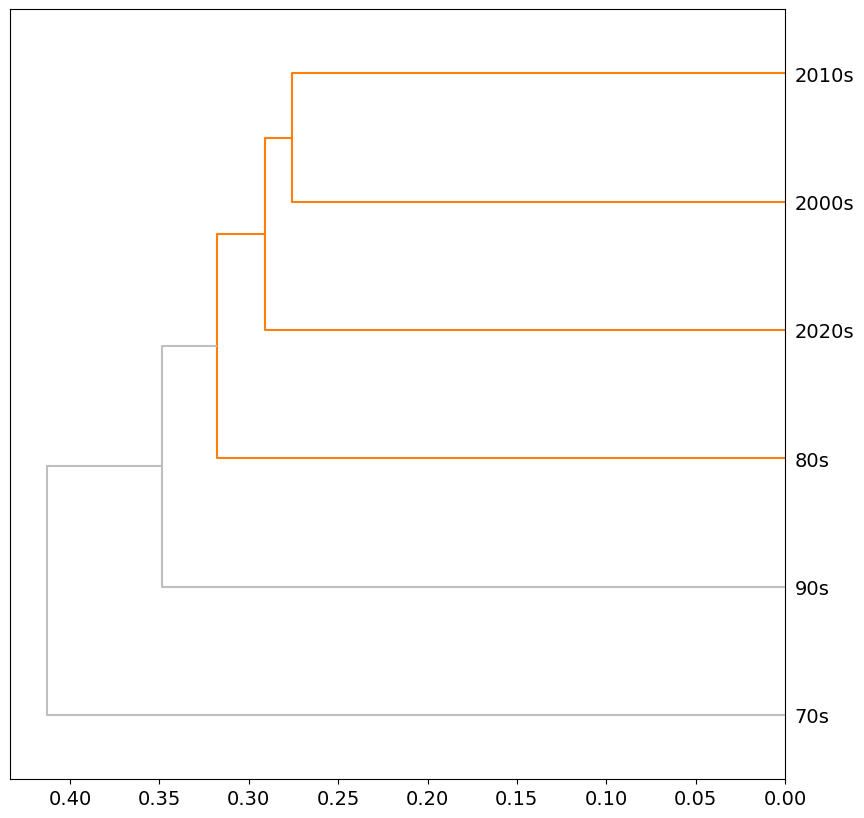

In [62]:
hierarchical_cluster(PAIRS.euclidean, linkage_method='average', color_thresh=PAIRS.euclidean.median())

<Figure size 640x480 with 0 Axes>

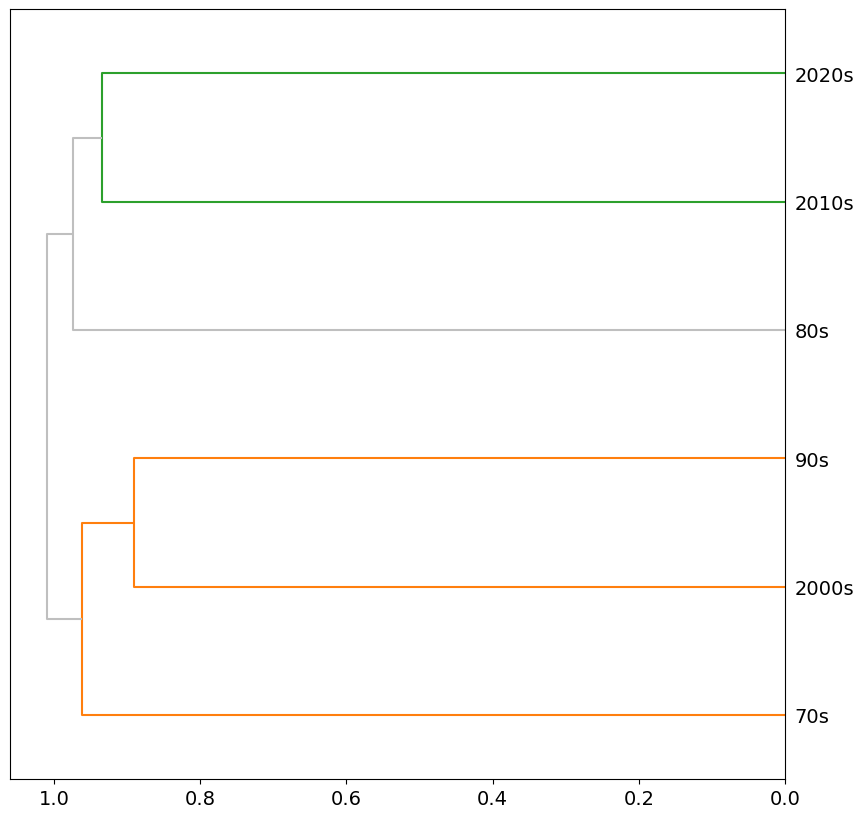

In [63]:
hierarchical_cluster(PAIRS.cosine, linkage_method='ward', color_thresh=PAIRS.cosine.median());

## RIFF 3

### Probabilistic TFIDF over the Decades

In [197]:
sample_terms = "brother sister husband wife war violence stress peace love sex dance club beat country guitar beer liquor drunk".split()

In [65]:
L1 = L1.reindex([3, 4, 5, 0, 1, 2])
L1.index = L1.index.map(decade_mapping)

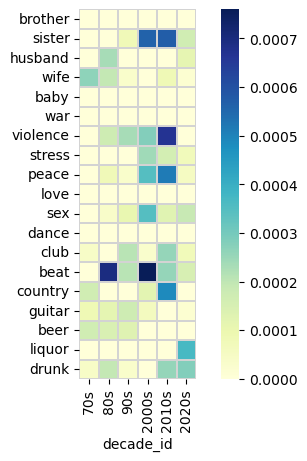

In [196]:
colors = "YlGnBu"
sns.heatmap(L1[sample_terms].T, cmap=colors, linewidth=.01, linecolor="lightgray", square=True);

Will spare you the visualization but take any explicit or controversial word you can think of and it will show the 2020s

In [171]:
def top_decades_for_term(term_str):
    X = BOW.join(LIB).query(f"term_str == '{term_str}'").groupby(['decade_id'])\
        .agg({'tfidf':'mean', 'n':'sum'})
    X.index = X.index.map(decade_mapping)

    return px.scatter(X.reset_index(), 'n','tfidf', color='decade_id', size='tfidf',
                      hover_name='decade_id', 
                      height=500, width=600, title=f"{term_str}")

In [172]:
top_decades_for_term('sex')

In [173]:
top_decades_for_term('violence')

In [199]:
top_decades_for_term('fuck')

In [200]:
top_decades_for_term('drunk')

## BONUS: RIFF 4

### Hierarchical Agglomerative Cluster Tree of Vector Space

*taken from the DS5001 Repo to get HAC function*

In [85]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist #, squareform
# from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt            

class HAC:
    """This class takes an arbitrary vector space and represents it 
    as a hierarhical agglomerative cluster tree. The number of observations
    should be sufficiently small to allow being plotted."""

    w:int = 10
    labelsize:int = 14
    orientation:str = 'left'
    sim_metric:str = 'cosine' # The distance metric to use. The distance function can be ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, ‘kulsinski’, ‘kulczynski1’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.
    tree_method:str = 'ward'
    norm:str = 'l2' # l1, l2, max
    
    def __init__(self, M, labels=None):
        self.M = M
        self.h = M.shape[0]
        if labels:
            self.labels = labels            
        else:
            self.labels = M.index.tolist()

    def get_sims(self):
        self.SIMS = pdist(normalize(self.M, norm=self.norm), metric=self.sim_metric)

    def get_tree(self):
        self.TREE = sch.linkage(self.SIMS, method=self.tree_method)        
        
    def plot_tree(self):
        plt.figure()
        fig, axes = plt.subplots(figsize=(self.w, self.h / 3))
        dendrogram = sch.dendrogram(self.TREE, labels=self.labels, orientation=self.orientation);
        plt.tick_params(axis='both', which='major', labelsize=self.labelsize)
        
    def plot(self):
        self.get_sims()
        self.get_tree()
        self.plot_tree()

<Figure size 640x480 with 0 Axes>

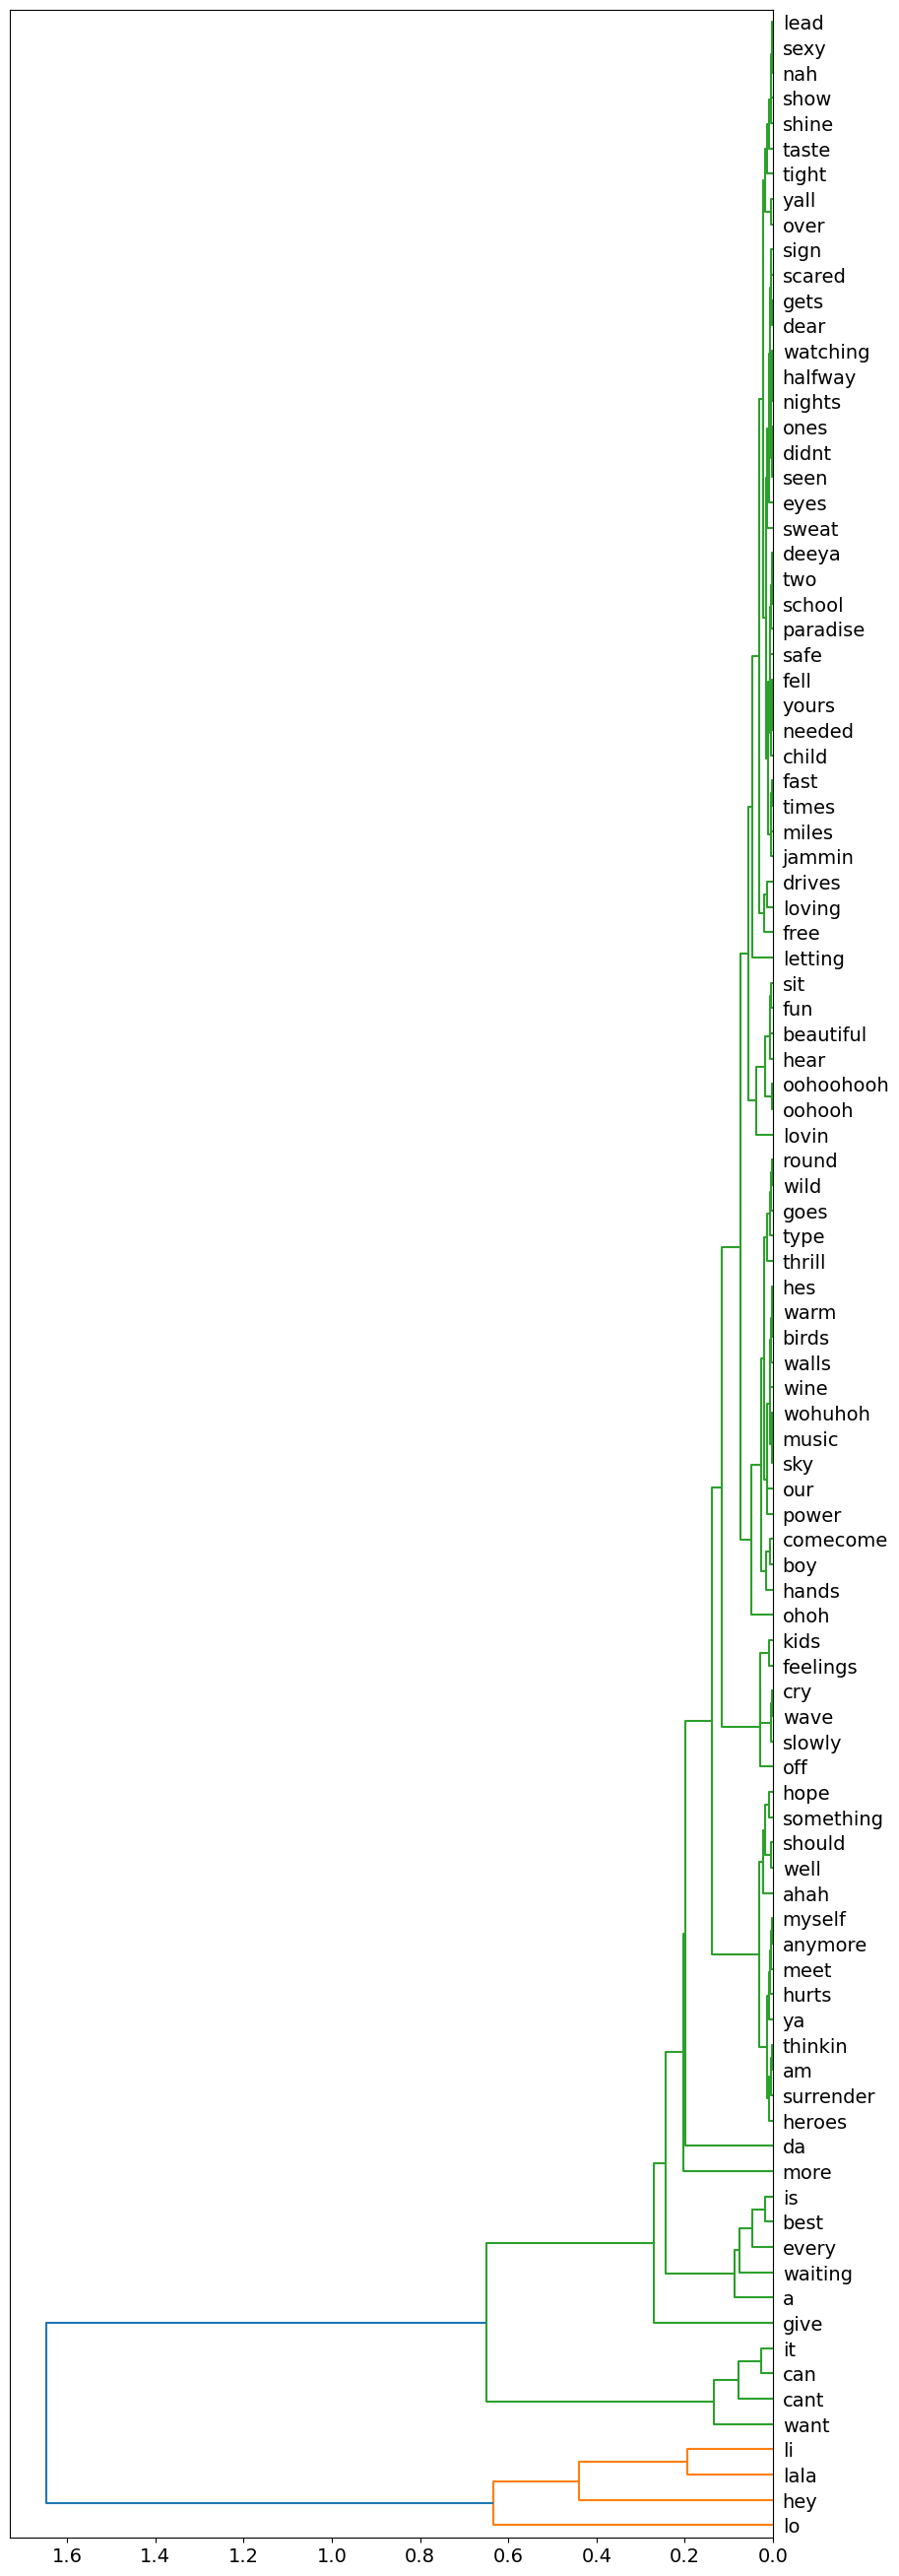

In [141]:
import sys

WV2 = WV.join(VOCAB.max_pos_group)
WV2 = WV2[~WV2.max_pos_group.str.match(r"NNPS?")].iloc[:, :-1]

HAC(WV2.sample(100)).plot()

# Write Out all Data Files

In [435]:
DCM.to_csv('data/model_tables/DCM.csv')
COMPINF.to_csv('data/model_tables/COMPINF.csv')
LOADINGS.to_csv('data/model_tables/LOADINGS.csv')

TOPICS.to_csv('data/model_tables/TOPICS.csv')
THETA.to_csv('data/model_tables/THETA.csv')
PHI.to_csv('data/model_tables/PHI.csv')

VOCAB_SENT.to_csv('data/model_tables/VOCAB_SENT.csv')
BOW_SENT.to_csv('data/model_tables/BOW_SENT.csv')
DOC_SENT.to_csv('data/model_tables/DOC_SENT.csv')

VOCAB_W2V.to_csv('data/model_tables/VOCAB_W2V.csv')
